# Exploration & Visualizations: Empirical Market Constraints

This notebook demonstrates the extraction and visualization of empirical market data (S&P 500 Historical Paths and Options Chains) to form the basis of our Rough Volatility Deep Learning datasets. **Monte Carlo simulations have been strictly removed.**

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import numpy as np
import pandas as pd
from scipy.interpolate import griddata
from src.market_paths import fetch_empirical_paths
from src.data_loader import download_spx_options
from src.visualize import plot_3d_volatility_surface

## 1. Historical Realized Roughness (S&P 500 and VIX)

Instead of simulating theoretical fractional Brownian motion paths, we pull the past 5 years of daily ^SPX and ^VIX data. The Deep BSDE will be trained on segments of these actual historical regimes to prevent the curse of dimensionality over unrealistic simulated states.

Loaded 1255 empirical historical trading days.


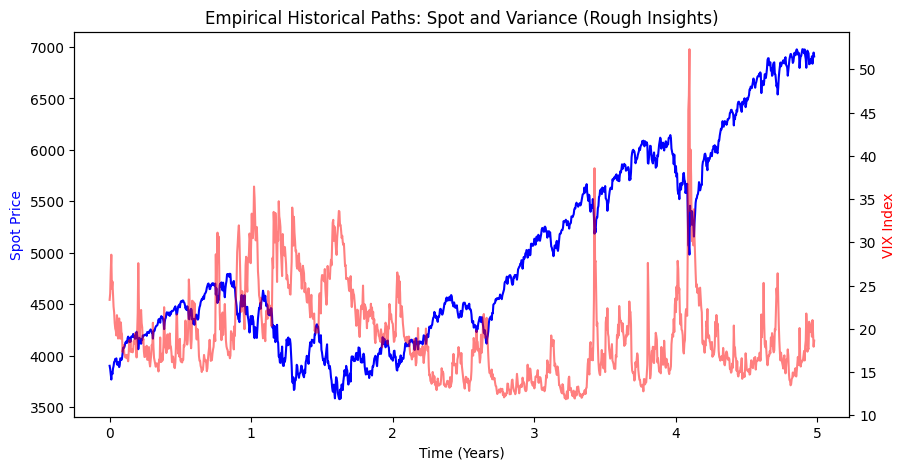

In [2]:
# Load empirical SPX and VIX paths
t_emp, S_emp, V_emp = fetch_empirical_paths()

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(t_emp, S_emp[0], 'b-', label="S&P 500 (Spot)")
ax1.set_xlabel('Time (Years)')
ax1.set_ylabel('Spot Price', color='b')

ax2 = ax1.twinx()
ax2.plot(t_emp, np.sqrt(V_emp[0]) * 100, 'r-', alpha=0.5, label="VIX (Implied Vol %)")
ax2.set_ylabel('VIX Index', color='r')
plt.title("Empirical Historical Paths: Spot and Variance (Rough Insights)")
plt.show()

## 2. 3D Live Implied Volatility Surfaces (S&P 500)
We pull live options chain data directly from Yahoo Finance. We then interpolate this scattered empirical data onto a grid to plot the authentic volatility smile/surface currently priced by the market.

In [3]:
# Download Empirical Data
data_path = download_spx_options("../Data")

if data_path:
    df = pd.read_csv(data_path)
    # Extract features
    maturities_raw = df['Maturity'].values
    strikes_raw = df['strike'].values
    ivs_raw = df['impliedVolatility'].values
    spot = df['Spot'].iloc[0]
    
    # Filter for strikes reasonably close to the money for plotting stability
    mask = (strikes_raw > spot * 0.8) & (strikes_raw < spot * 1.2)
    m_f, s_f, i_f = maturities_raw[mask], strikes_raw[mask], ivs_raw[mask]
    
    # Create a structured grid for the 3D Plotly Surface
    grid_m, grid_s = np.mgrid[min(m_f):max(m_f):30j, min(s_f):max(s_f):30j]
    
    # Interpolate empirical scattered data onto the grid
    grid_iv = griddata((m_f, s_f), i_f, (grid_m, grid_s), method='cubic', fill_value=np.nan)
    
    # Impute NaNs created by cubic interpolation outside the convex hull using nearest neighbor
    grid_iv_nearest = griddata((m_f, s_f), i_f, (grid_m, grid_s), method='nearest')
    grid_iv = np.where(np.isnan(grid_iv), grid_iv_nearest, grid_iv)
    
    plot_3d_volatility_surface(
        maturities=grid_m[:, 0], 
        strikes=grid_s[0, :], 
        ivs=grid_iv.T, 
        title=f"LIVE S&P 500 Implied Volatility Surface (Spot = {spot:.2f})"
    )
else:
    print("Could not fetch live options data. Check your market hours/connection.")

Extracting ^SPX (S&P 500) options chain...
Successfully processed 737 empirical SPX option quotes to ../Data\SPX_options_chain_20260227.csv
